#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [3]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [4]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
import torch
import torch.nn as nn
import torch.optim as optim
from time import sleep
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [5]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 223MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.
(10, 224, 224, 3) (10,)
Got numpy array of shape (224, 224, 3), and label with code 5.
Label code corresponds to MUS class.


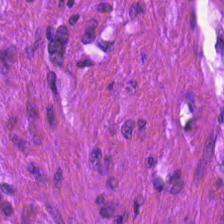

In [6]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
img1, lbl1 = d_train_tiny.random_batch_with_labels(10)
print(img1.shape, lbl1.shape)
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [7]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

#Матрица Ошибок и визуализирующих процесс обучения


матрицы ошибок, которая показывает, как предсказания модели соотносятся с истинными метками классов. Функция также вычисляет True Positive (TP) и False Positive (FP) для каждого класса.

Используем confusion_matrix из библиотеки sklearn для подсчёта количества совпадений между предсказанными и истинными метками классов.

Визуализируем матрицу ошибок: Построение тепловой карты (heatmap) с использованием библиотеки seaborn для наглядного отображения.

Вычисляет метрики для каждого класса: TP (True Positive): Количество правильных предсказаний для данного класса. FP (False Positive): Количество случаев, когда данный класс был предсказан неправильно. Выводит метрики в табличной форме.

In [8]:
#LBL5
def confi_matrix(gt: List[int], pred: List[int], class_names: List[str]):
    matrix = confusion_matrix(gt, pred)

    plt.figure(figsize=(10, 8), dpi=100)
    sns.heatmap(matrix,
                xticklabels=class_names,
                yticklabels=class_names,
                cmap='RdYlGn',
                center=0,
                annot=True,
                fmt="d",
                cbar_kws={'label': 'Number of Samples'})

    plt.title('Confusion Matrix', fontsize=22, pad=20)
    plt.xlabel('Predicted Labels', fontsize=16, labelpad=10)
    plt.ylabel('True Labels', fontsize=16, labelpad=10)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.show()

    TP = np.diag(matrix)
    FP = matrix.sum(axis=0) - TP

    print(f"{'Class':<15}{'True Positive (TP)':<20}{'False Positive (FP)':<20}")
    print("-" * 55)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<15}{TP[i]:<20}{FP[i]:<20}")

#LBL4
def plot_train_process(loss_list, num_epochs, title="Training Loss Over Epochs"):
    epoch_list = list(range(1, num_epochs + 1))

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, loss_list, marker='o', linestyle='-', color='b', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


---
### Класс Model


In [16]:

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 9)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = self.pool(torch.relu(self.bn5(self.conv5(x))))
        x = self.pool(torch.relu(self.bn6(self.conv6(x))))
        x = torch.relu(self.bn7(self.conv7(x)))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def save(self, name: str):
        save_dir = '/content/drive/MyDrive/DP'
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{name}.pth')
        torch.save(self.state_dict(), save_path)
        print(f"Model saved to {save_path}")

    def load(self, name: str):
        name_to_id_dict = {
            "best": "1-8b5rIL6ppsynjG7MAWDffl4pVxjjx9U"
        }

        if name not in name_to_id_dict:
            raise ValueError(f"Unknown model name '{name}'. Available: {list(name_to_id_dict.keys())}")

        file_id = name_to_id_dict[name]
        output = f"{name}.pth"
        gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

        self.load_state_dict(torch.load(output))
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.eval()
        print(f"Model loaded from {output}")

    #LBL2
    def normalize_inputs(self, images, mean, std):
        mean = torch.tensor(mean).view(1, -1, 1, 1)  # Преобразуем mean в формат (1, C, 1, 1)
        std = torch.tensor(std).view(1, -1, 1, 1)    # Преобразуем std в формат (1, C, 1, 1)

        normalized_images = (images - mean) / std
        return normalized_images

    def train_model(self, dataset, batch_size=32, num_epochs=60, learning_rate=0.001):

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        print(f"Training on device: {device}")
        loss_list = []
        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            n_batches = dataset.n_files // batch_size

            for _ in tqdm(range(n_batches), desc=f"Epoch {epoch+1}/{num_epochs}"):
                inputs, labels = dataset.random_batch_with_labels(batch_size)
                inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 3, 1, 2)  # Преобразуем (N, H, W, C) -> (N, C, H, W)
                labels = torch.tensor(labels, dtype=torch.long)

                inputs = self.normalize_inputs(inputs, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = self(inputs)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            loss_list.append(running_loss / n_batches)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / n_batches:.4f}")

        return loss_list, num_epochs

    def test_on_dataset(self, dataset, limit=None):
        self.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        with torch.no_grad():
            for img in tqdm(dataset.images_seq(n), total=n):
                inputs = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # (H, W, C) -> (1, C, H, W)
                inputs = self.normalize_inputs(inputs, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                inputs = inputs.to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                predictions.append(predicted.item())
        return predictions

    def test_on_image(self, img: np.ndarray):
        self.eval()
        with torch.no_grad():
            img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # (H, W, C) -> (1, C, H, W)

            img_tensor = self.normalize_inputs(img_tensor,mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            outputs = self(img_tensor)

            _, predicted_class = torch.max(outputs, 1)

            return predicted_class.item()


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [10]:
d_train = Dataset('train')
d_test = Dataset('test')
d_train_small = Dataset('train_small')
d_test_small = Dataset('test_small')
d_train_tiny = Dataset('train_tiny')
d_test_tiny = Dataset('test_tiny')



Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:10<00:00, 205MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr
To: /content/test.npz
100%|██████████| 525M/525M [00:03<00:00, 147MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR
To: /content/train_small.npz
100%|██████████| 841M/841M [00:06<00:00, 127MB/s]


Loading dataset train_small from npz.
Done. Dataset train_small consists of 7200 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI
To: /content/test_small.npz
100%|██████████| 211M/211M [00:01<00:00, 153MB/s]


Loading dataset test_small from npz.
Done. Dataset test_small consists of 1800 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 255MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 75.9MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


In [11]:
model = Model()
if not EVALUATE_ONLY:
    loss_list, num_epochs = model.train_model(d_train)
    model.save('best')
else:
    #todo: your link goes here
    model.load('best')

Training on device: cuda


Epoch 1/60: 100%|██████████| 562/562 [01:25<00:00,  6.55it/s]


Epoch [1/60], Loss: 0.9580


Epoch 2/60: 100%|██████████| 562/562 [01:23<00:00,  6.71it/s]


Epoch [2/60], Loss: 0.5926


Epoch 3/60: 100%|██████████| 562/562 [01:25<00:00,  6.61it/s]


Epoch [3/60], Loss: 0.4085


Epoch 4/60: 100%|██████████| 562/562 [01:23<00:00,  6.70it/s]


Epoch [4/60], Loss: 0.3162


Epoch 5/60: 100%|██████████| 562/562 [01:24<00:00,  6.69it/s]


Epoch [5/60], Loss: 0.2613


Epoch 6/60: 100%|██████████| 562/562 [01:23<00:00,  6.70it/s]


Epoch [6/60], Loss: 0.2321


Epoch 7/60: 100%|██████████| 562/562 [01:23<00:00,  6.73it/s]


Epoch [7/60], Loss: 0.2183


Epoch 8/60: 100%|██████████| 562/562 [01:23<00:00,  6.75it/s]


Epoch [8/60], Loss: 0.2096


Epoch 9/60: 100%|██████████| 562/562 [01:26<00:00,  6.48it/s]


Epoch [9/60], Loss: 0.1773


Epoch 10/60: 100%|██████████| 562/562 [01:29<00:00,  6.31it/s]


Epoch [10/60], Loss: 0.1656


Epoch 11/60: 100%|██████████| 562/562 [01:28<00:00,  6.36it/s]


Epoch [11/60], Loss: 0.1545


Epoch 12/60: 100%|██████████| 562/562 [01:28<00:00,  6.35it/s]


Epoch [12/60], Loss: 0.1376


Epoch 13/60: 100%|██████████| 562/562 [01:28<00:00,  6.38it/s]


Epoch [13/60], Loss: 0.1201


Epoch 14/60: 100%|██████████| 562/562 [01:27<00:00,  6.39it/s]


Epoch [14/60], Loss: 0.1160


Epoch 15/60: 100%|██████████| 562/562 [01:28<00:00,  6.35it/s]


Epoch [15/60], Loss: 0.1132


Epoch 16/60: 100%|██████████| 562/562 [01:27<00:00,  6.46it/s]


Epoch [16/60], Loss: 0.1035


Epoch 17/60: 100%|██████████| 562/562 [01:23<00:00,  6.75it/s]


Epoch [17/60], Loss: 0.0964


Epoch 18/60: 100%|██████████| 562/562 [01:23<00:00,  6.72it/s]


Epoch [18/60], Loss: 0.0914


Epoch 19/60: 100%|██████████| 562/562 [01:24<00:00,  6.64it/s]


Epoch [19/60], Loss: 0.0857


Epoch 20/60: 100%|██████████| 562/562 [01:24<00:00,  6.63it/s]


Epoch [20/60], Loss: 0.0846


Epoch 21/60: 100%|██████████| 562/562 [01:24<00:00,  6.61it/s]


Epoch [21/60], Loss: 0.0766


Epoch 22/60: 100%|██████████| 562/562 [01:25<00:00,  6.56it/s]


Epoch [22/60], Loss: 0.0634


Epoch 23/60: 100%|██████████| 562/562 [01:25<00:00,  6.60it/s]


Epoch [23/60], Loss: 0.0785


Epoch 24/60: 100%|██████████| 562/562 [01:23<00:00,  6.69it/s]


Epoch [24/60], Loss: 0.0646


Epoch 25/60: 100%|██████████| 562/562 [01:22<00:00,  6.81it/s]


Epoch [25/60], Loss: 0.0672


Epoch 26/60: 100%|██████████| 562/562 [01:22<00:00,  6.79it/s]


Epoch [26/60], Loss: 0.0631


Epoch 27/60: 100%|██████████| 562/562 [01:22<00:00,  6.80it/s]


Epoch [27/60], Loss: 0.0564


Epoch 28/60: 100%|██████████| 562/562 [01:22<00:00,  6.82it/s]


Epoch [28/60], Loss: 0.0555


Epoch 29/60: 100%|██████████| 562/562 [01:22<00:00,  6.82it/s]


Epoch [29/60], Loss: 0.0536


Epoch 30/60: 100%|██████████| 562/562 [01:21<00:00,  6.87it/s]


Epoch [30/60], Loss: 0.0484


Epoch 31/60: 100%|██████████| 562/562 [01:21<00:00,  6.89it/s]


Epoch [31/60], Loss: 0.0515


Epoch 32/60: 100%|██████████| 562/562 [01:21<00:00,  6.86it/s]


Epoch [32/60], Loss: 0.0451


Epoch 33/60: 100%|██████████| 562/562 [01:22<00:00,  6.82it/s]


Epoch [33/60], Loss: 0.0526


Epoch 34/60: 100%|██████████| 562/562 [01:22<00:00,  6.80it/s]


Epoch [34/60], Loss: 0.0403


Epoch 35/60: 100%|██████████| 562/562 [01:22<00:00,  6.77it/s]


Epoch [35/60], Loss: 0.0441


Epoch 36/60: 100%|██████████| 562/562 [01:23<00:00,  6.75it/s]


Epoch [36/60], Loss: 0.0485


Epoch 37/60: 100%|██████████| 562/562 [01:22<00:00,  6.79it/s]


Epoch [37/60], Loss: 0.0384


Epoch 38/60: 100%|██████████| 562/562 [01:22<00:00,  6.78it/s]


Epoch [38/60], Loss: 0.0408


Epoch 39/60: 100%|██████████| 562/562 [01:22<00:00,  6.79it/s]


Epoch [39/60], Loss: 0.0333


Epoch 40/60: 100%|██████████| 562/562 [01:22<00:00,  6.83it/s]


Epoch [40/60], Loss: 0.0331


Epoch 41/60: 100%|██████████| 562/562 [01:22<00:00,  6.80it/s]


Epoch [41/60], Loss: 0.0401


Epoch 42/60: 100%|██████████| 562/562 [01:22<00:00,  6.83it/s]


Epoch [42/60], Loss: 0.0313


Epoch 43/60: 100%|██████████| 562/562 [01:22<00:00,  6.82it/s]


Epoch [43/60], Loss: 0.0358


Epoch 44/60: 100%|██████████| 562/562 [01:22<00:00,  6.80it/s]


Epoch [44/60], Loss: 0.0290


Epoch 45/60: 100%|██████████| 562/562 [01:22<00:00,  6.78it/s]


Epoch [45/60], Loss: 0.0244


Epoch 46/60: 100%|██████████| 562/562 [01:22<00:00,  6.79it/s]


Epoch [46/60], Loss: 0.0335


Epoch 47/60: 100%|██████████| 562/562 [01:22<00:00,  6.83it/s]


Epoch [47/60], Loss: 0.0238


Epoch 48/60: 100%|██████████| 562/562 [01:22<00:00,  6.78it/s]


Epoch [48/60], Loss: 0.0332


Epoch 49/60: 100%|██████████| 562/562 [01:24<00:00,  6.68it/s]


Epoch [49/60], Loss: 0.0290


Epoch 50/60: 100%|██████████| 562/562 [01:25<00:00,  6.59it/s]


Epoch [50/60], Loss: 0.0319


Epoch 51/60: 100%|██████████| 562/562 [01:25<00:00,  6.59it/s]


Epoch [51/60], Loss: 0.0368


Epoch 52/60: 100%|██████████| 562/562 [01:25<00:00,  6.60it/s]


Epoch [52/60], Loss: 0.0254


Epoch 53/60: 100%|██████████| 562/562 [01:24<00:00,  6.63it/s]


Epoch [53/60], Loss: 0.0281


Epoch 54/60: 100%|██████████| 562/562 [01:24<00:00,  6.62it/s]


Epoch [54/60], Loss: 0.0251


Epoch 55/60: 100%|██████████| 562/562 [01:24<00:00,  6.63it/s]


Epoch [55/60], Loss: 0.0229


Epoch 56/60: 100%|██████████| 562/562 [01:24<00:00,  6.62it/s]


Epoch [56/60], Loss: 0.0257


Epoch 57/60: 100%|██████████| 562/562 [01:24<00:00,  6.64it/s]


Epoch [57/60], Loss: 0.0250


Epoch 58/60: 100%|██████████| 562/562 [01:24<00:00,  6.65it/s]


Epoch [58/60], Loss: 0.0219


Epoch 59/60: 100%|██████████| 562/562 [01:23<00:00,  6.70it/s]


Epoch [59/60], Loss: 0.0219


Epoch 60/60: 100%|██████████| 562/562 [01:24<00:00,  6.64it/s]


Epoch [60/60], Loss: 0.0320
Model saved to /content/drive/MyDrive/DP/best.pth


In [ ]:
model1 = Model()
model1.load('best1')

Downloading...
From: https://drive.google.com/uc?id=1-DmB6PngqHZ6oFq8eru_-sK1sSqKzTt2
To: /content/best1.pth
100%|██████████| 18.4M/18.4M [00:00<00:00, 76.3MB/s]

Model loaded from best1.pth



<ipython-input-81-de2c1a8b56df>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(output))


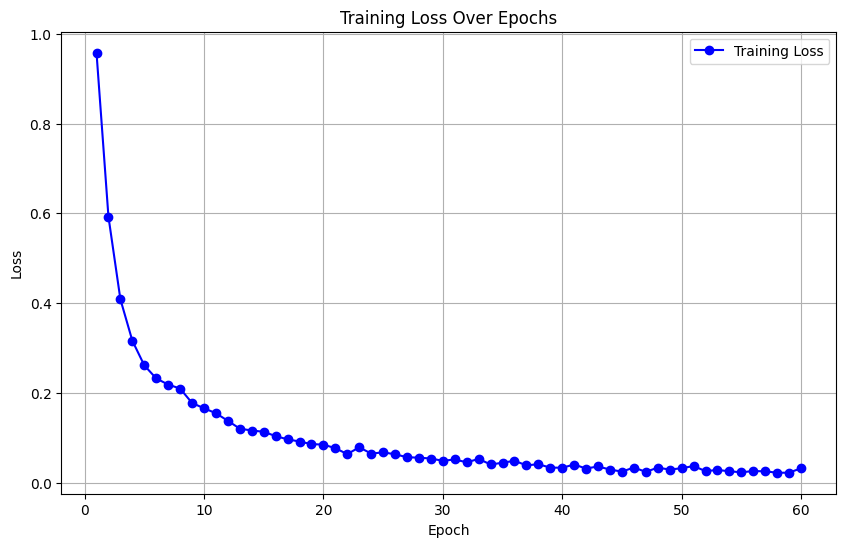

In [12]:
plot_train_process(loss_list, num_epochs)

Пример тестирования модели на части набора данных:

In [13]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test_tiny, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

100%|██████████| 9/9 [00:00<00:00, 92.62it/s]

metrics for 10% of test:
	 accuracy 1.0000:
	 balanced accuracy 1.0000:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Пример тестирования модели на полном наборе данных:

100%|██████████| 4500/4500 [00:13<00:00, 332.28it/s]


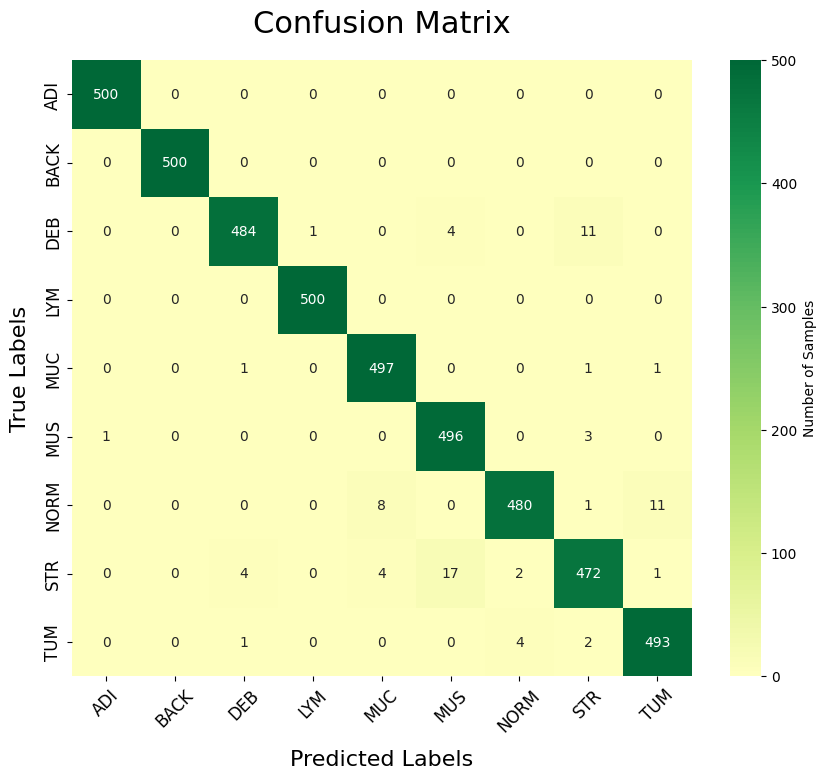

Class          True Positive (TP)  False Positive (FP) 
-------------------------------------------------------
ADI            500                 1                   
BACK           500                 0                   
DEB            484                 6                   
LYM            500                 1                   
MUC            497                 12                  
MUS            496                 21                  
NORM           480                 6                   
STR            472                 18                  
TUM            493                 13                  
metrics for test:
	 accuracy 0.9827:
	 balanced accuracy 0.9827:


In [14]:
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    confi_matrix(d_test.labels, pred_2,  TISSUE_CLASSES)
    Metrics.print_all(d_test.labels, pred_2, 'test')

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [17]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Downloading...
From: https://drive.google.com/uc?id=1-8b5rIL6ppsynjG7MAWDffl4pVxjjx9U
To: /content/best.pth
100%|██████████| 18.4M/18.4M [00:00<00:00, 114MB/s] 
<ipython-input-16-6e6482b1c2bb>:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an i

Model loaded from best.pth


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 192MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


100%|██████████| 90/90 [00:00<00:00, 300.73it/s]


metrics for test-tiny:
	 accuracy 0.9556:
	 balanced accuracy 0.9556:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"